In [1]:
import pandas as pd
import numpy as np
import plotly as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import tree

pio.renderers.default = "browser"

<h3> Load the data from source </h3>

In [2]:
# pull shot data - note that this is from github - https://github.com/sealneaward/nba-movement-data

raw = pd.read_csv('data/shots_fixed.csv')
dropped = raw.drop(columns = ['EVENT_TYPE', 'GAME_EVENT_ID', 'GAME_DATE', 'GAME_ID'])

dropped.head(10)

,ACTION_TYPE,EVENTTIME,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,PERIOD,PLAYER_ID,PLAYER_NAME,...,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Jump Shot,215,Shot Chart Detail,LAL,-23.9825,157.0968,3,1,101138,Brandon Bass,...,15,0,218.50,2PT Field Goal,Center(C),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
1,Dunk Shot,191,Shot Chart Detail,LAL,224.3221,24.9662,3,1,101138,Brandon Bass,...,0,1,204.83,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
2,Jump Shot,518,Shot Chart Detail,LAL,-5.4122,173.0601,8,2,101138,Brandon Bass,...,16,1,520.65,2PT Field Goal,Center(C),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,OKC
3,Jump Shot,120,Shot Chart Detail,LAL,-25.9351,158.7570,2,3,101138,Brandon Bass,...,15,0,123.26,2PT Field Goal,Center(C),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
4,Jump Shot,646,Shot Chart Detail,LAL,178.3350,20.1712,10,1,201579,Roy Hibbert,...,15,1,650.49,2PT Field Goal,Right Side(R),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
5,Hook Shot,552,Shot Chart Detail,LAL,100.3073,98.9265,9,1,201579,Roy Hibbert,...,5,0,546.23,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
6,Hook Shot,430,Shot Chart Detail,LAL,111.9160,222.6307,7,1,201579,Roy Hibbert,...,4,0,449.90,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
7,Hook Shot,590,Shot Chart Detail,LAL,-92.6563,65.3523,9,3,201579,Roy Hibbert,...,5,0,593.22,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
8,Jump Shot,401,Shot Chart Detail,LAL,-216.1135,-10.5376,6,1,1626204,Larry Nance Jr.,...,13,1,408.84,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
9,Layup Shot,273,Shot Chart Detail,LAL,-219.9258,16.3056,4,2,1626204,Larry Nance Jr.,...,1,0,297.98,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC


Get the shots grouped by player in a dictionary

<h3> Compute the shooting average for each player </h3>

In [3]:

playerDict = {} # first is player name, second is their shots

# get list of ids
playerIds = dropped.PLAYER_ID.unique()

# make dictionary with empty arrays for each player's shots
for pid in playerIds:
    playerDict[pid] = []

# for each shot, add it to the player ID's array
for index, row in dropped.iterrows():
    innerPid = row['PLAYER_ID']
    shotMade = row['SHOT_MADE_FLAG']
    
    playerDict[innerPid].append(shotMade)

In [4]:
# try 2
playerAvgGrouped = dropped.groupby('PLAYER_ID', as_index=False)['SHOT_MADE_FLAG'].mean()
playerAverages = playerAvgGrouped.set_index(playerAvgGrouped['PLAYER_ID'])

In [5]:
shotAvgDict = {}

# get average of python list
def avg(l): 
    return sum(l) / len(l) 

for p in playerDict.keys():
    shotAvgDict[p] = avg(playerDict[p])
    
shotAvgDict

{np.int64(101138): 0.568,
 np.int64(201579): 0.45098039215686275,
 np.int64(1626204): 0.5616438356164384,
 np.int64(2555): 0.43333333333333335,
 np.int64(201586): 0.5083798882681564,
 np.int64(1626148): 0.2608695652173913,
 np.int64(201142): 0.5022421524663677,
 np.int64(202713): 0.4,
 np.int64(202683): 0.5697211155378487,
 np.int64(203527): 0.45614035087719296,
 np.int64(203135): 0.425,
 np.int64(977): 0.3492063492063492,
 np.int64(201571): 0.36231884057971014,
 np.int64(203500): 0.6148148148148148,
 np.int64(201566): 0.45132743362831856,
 np.int64(1626166): 0.41228070175438597,
 np.int64(203903): 0.44170403587443946,
 np.int64(1626156): 0.4250614250614251,
 np.int64(203460): 0.512,
 np.int64(201627): 0.41379310344827586,
 np.int64(203079): 0.38513513513513514,
 np.int64(101150): 0.40540540540540543,
 np.int64(1626273): 0.45161290322580644,
 np.int64(200779): 0.5,
 np.int64(203458): 0.4486486486486487,
 np.int64(201978): 0.4214876033057851,
 np.int64(203141): 0.43309859154929575,
 np.

In [6]:
# copy
full = dropped.sample(frac = 1)
full['PLAYER_AVG'] = ''

# add average -> This takes a bit for me. About 9 mins on my machine
# Will go to OH to try to speed it up, but until then, we can just use the outputted CSV 
for index, row in full.iterrows():
    full.loc[full['PLAYER_ID'] == row['PLAYER_ID'], 'PLAYER_AVG'] = shotAvgDict[row['PLAYER_ID']]

<h4> Load to csv so we don't have to rerun this every time </h4>

In [7]:
full.to_csv('fullDF.csv')

<h2> Data Analysis and ML </h2>

<h4> Get full csv </h4>

In [8]:
fullDF = pd.read_csv('fullDF.csv')

<h4> Drop irrelevant columns</h4>

In [9]:
# drop irrelevant columns
fullDF = fullDF.loc[:, ~fullDF.columns.str.contains('^Unnamed')]
fullDF.drop(columns = ['EVENTTIME', 'GRID_TYPE', 'PLAYER_ID', 'SHOT_ATTEMPTED_FLAG', 'TEAM_ID'], inplace = True)

<h4> Use entropy to find which columns to drop </h4>

First one hot encode and break into preliminary testing and training data

Now see likelihood of making a shot based on different correlations (this takes about 2 minutes on my machine)

In [10]:
# try with everything
categorical_cols = ['ACTION_TYPE', 'HTM', 'PERIOD', 'PLAYER_NAME', 'QUARTER', 'SHOT_TYPE', 'SHOT_ZONE_AREA',
                    'SHOT_ZONE_BASIC', 'SHOT_ZONE_RANGE', 'TEAM_NAME', 'VTM']

def onehot_encode(data):
    for feature in categorical_cols:
        one_hot = pd.get_dummies(data[feature], prefix=feature)
        data = data.drop(feature, axis = 1)
        data = data.join(one_hot)
    return data

featPrelim = onehot_encode(fullDF)
featPrelim

,LOC_X,LOC_Y,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,PLAYER_AVG,ACTION_TYPE_Alley Oop Dunk Shot,ACTION_TYPE_Alley Oop Layup shot,...,VTM_OKC,VTM_ORL,VTM_PHI,VTM_PHX,VTM_POR,VTM_SAC,VTM_SAS,VTM_TOR,VTM_UTA,VTM_WAS
0,-19.2652,34.9886,4,51,0,1,310.03,0.482353,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-212.2147,20.6095,4,19,19,1,281.61,0.508380,False,False,...,False,False,False,False,False,True,False,False,False,False
2,-28.4353,128.8564,8,50,15,1,533.27,0.525000,False,False,...,False,False,False,False,False,False,False,False,False,False
3,200.8854,134.0966,10,5,17,1,619.90,0.442786,False,False,...,False,False,False,True,False,False,False,False,False,False
4,168.1975,181.6562,0,45,25,1,47.87,0.432348,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84462,-43.9750,124.8604,8,50,16,1,538.14,0.417840,False,False,...,False,False,False,False,False,False,False,False,False,False
84463,-144.0775,115.8811,4,58,19,0,300.28,0.413534,False,False,...,False,False,True,False,False,False,False,False,False,False
84464,22.5298,263.5020,9,20,24,1,562.25,0.424951,False,False,...,False,False,False,False,False,False,False,False,False,False
84465,-127.1619,168.4349,4,11,8,1,231.24,0.460993,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
correlation_df = featPrelim.corr()[['SHOT_MADE_FLAG']]
correlation_df.rename(columns={"SHOT_MADE_FLAG": "correlation_with_making_shot"}, inplace=True)
correlation_df

,correlation_with_making_shot
LOC_X,0.007481
LOC_Y,-0.036743
MINUTES_REMAINING,0.011510
SECONDS_REMAINING,0.010951
SHOT_DISTANCE,-0.187651
...,...
VTM_SAC,0.004892
VTM_SAS,0.003040
VTM_TOR,-0.004145
VTM_UTA,0.000401


Check for features that have a correlation above 0.03

In [12]:
relevant_cols = correlation_df.loc[correlation_df['correlation_with_making_shot'] >= 0.03]
relevant_cols

,correlation_with_making_shot
SHOT_MADE_FLAG,1.000000
PLAYER_AVG,0.120922
ACTION_TYPE_Alley Oop Dunk Shot,0.074933
ACTION_TYPE_Cutting Dunk Shot,0.082773
ACTION_TYPE_Cutting Finger Roll Layup Shot,0.038050
ACTION_TYPE_Cutting Layup Shot,0.085503
ACTION_TYPE_Driving Dunk Shot,0.072543
ACTION_TYPE_Driving Finger Roll Layup Shot,0.060802
ACTION_TYPE_Driving Layup Shot,0.076853
ACTION_TYPE_Dunk Shot,0.108120


From this, we gather that the most important features are the player's average, shot zone, shot distance, location, and action/shot type

In [13]:
dataset_imp_features_only = fullDF[['SHOT_MADE_FLAG', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE',
                                    'PLAYER_AVG', 'SHOT_TYPE', 'ACTION_TYPE', 'SHOT_DISTANCE', 'LOC_Y', 'LOC_X']]
dataset_imp_features_only

,SHOT_MADE_FLAG,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,PLAYER_AVG,SHOT_TYPE,ACTION_TYPE,SHOT_DISTANCE,LOC_Y,LOC_X
0,1,Restricted Area,Center(C),Less Than 8 ft.,0.482353,2PT Field Goal,Running Dunk Shot,0,34.9886,-19.2652
1,1,Mid-Range,Center(C),16-24 ft.,0.508380,2PT Field Goal,Jump Shot,19,20.6095,-212.2147
2,1,Mid-Range,Center(C),8-16 ft.,0.525000,2PT Field Goal,Jump Shot,15,128.8564,-28.4353
3,1,Mid-Range,Left Side(L),16-24 ft.,0.442786,2PT Field Goal,Jump Shot,17,134.0966,200.8854
4,1,Above the Break 3,Right Side Center(RC),24+ ft.,0.432348,3PT Field Goal,Step Back Jump shot,25,181.6562,168.1975
...,...,...,...,...,...,...,...,...,...,...
84462,1,Mid-Range,Left Side Center(LC),16-24 ft.,0.417840,2PT Field Goal,Running Jump Shot,16,124.8604,-43.9750
84463,0,Mid-Range,Left Side Center(LC),16-24 ft.,0.413534,2PT Field Goal,Pullup Jump shot,19,115.8811,-144.0775
84464,1,Above the Break 3,Right Side Center(RC),24+ ft.,0.424951,3PT Field Goal,Jump Shot,24,263.5020,22.5298
84465,1,In The Paint (Non-RA),Left Side(L),8-16 ft.,0.460993,2PT Field Goal,Floating Jump shot,8,168.4349,-127.1619


One hot encode again, but only on the important features

In [14]:
categorical_cols = ['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PLAYER_AVG', 'SHOT_TYPE', 'ACTION_TYPE']

def onehot_encode(data):
    for feature in categorical_cols:
        one_hot = pd.get_dummies(data[feature], prefix=feature)
        data = data.drop(feature, axis = 1)
        data = data.join(one_hot)
    return data

important_features_df = onehot_encode(dataset_imp_features_only)
important_features_df

,SHOT_MADE_FLAG,SHOT_DISTANCE,LOC_Y,LOC_X,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_Backcourt,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,...,ACTION_TYPE_Step Back Bank Jump Shot,ACTION_TYPE_Step Back Jump shot,ACTION_TYPE_Tip Dunk Shot,ACTION_TYPE_Tip Layup Shot,ACTION_TYPE_Turnaround Bank Hook Shot,ACTION_TYPE_Turnaround Bank shot,ACTION_TYPE_Turnaround Fadeaway Bank Jump Shot,ACTION_TYPE_Turnaround Fadeaway shot,ACTION_TYPE_Turnaround Hook Shot,ACTION_TYPE_Turnaround Jump Shot
0,1,0,34.9886,-19.2652,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,1,19,20.6095,-212.2147,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,1,15,128.8564,-28.4353,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,1,17,134.0966,200.8854,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,1,25,181.6562,168.1975,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84462,1,16,124.8604,-43.9750,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
84463,0,19,115.8811,-144.0775,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
84464,1,24,263.5020,22.5298,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
84465,1,8,168.4349,-127.1619,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<h4> Data Exploration and graphs </h4>

In [15]:
smallSamp = dropped.loc[dropped['PLAYER_ID'] == 201939]
medSamp = dropped.sample(3000)

In [16]:
fig = px.scatter(medSamp, x='LOC_X',  y='LOC_Y', color = 'SHOT_MADE_FLAG')
fig.show()

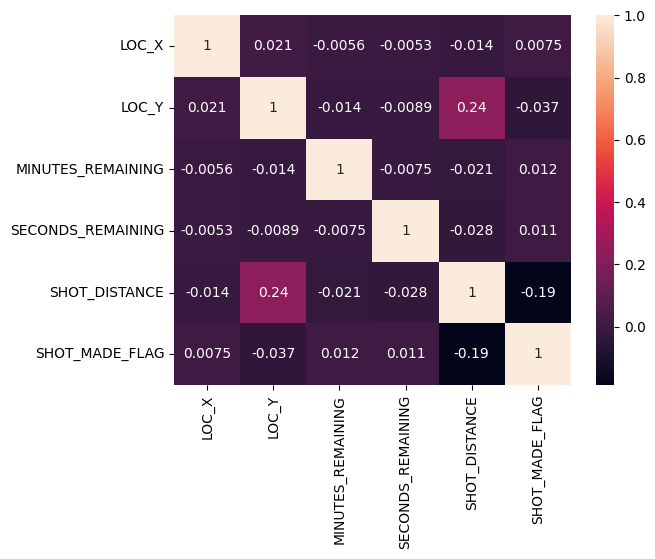

In [17]:
droppedImportant = dropped.drop(columns = ['EVENTTIME', 'PERIOD', 'QUARTER', 'SHOT_ATTEMPTED_FLAG', 'PLAYER_ID', 'TEAM_ID', 'SHOT_TIME'])
# Select only numeric columns for correlation
numeric_cols = droppedImportant.select_dtypes(include=[np.number])
cm = numeric_cols.corr()
sn.heatmap(cm, annot=True)
plt.show()

<h4> Separate target and features</h4>

In [18]:
# try with everything
categorical_cols = ['ACTION_TYPE', 'HTM', 'PERIOD', 'PLAYER_NAME', 'QUARTER', 'SHOT_TYPE', 'SHOT_ZONE_AREA',
                    'SHOT_ZONE_BASIC', 'SHOT_ZONE_RANGE', 'TEAM_NAME', 'VTM']

def onehot_encode(data):
    for feature in categorical_cols:
        one_hot = pd.get_dummies(data[feature], prefix=feature)
        data = data.drop(feature, axis = 1)
        data = data.join(one_hot)
    return data

fullDFOHE = onehot_encode(fullDF)

target = fullDFOHE['SHOT_MADE_FLAG']
features = fullDFOHE.drop(columns = ['SHOT_MADE_FLAG'])

sample = fullDFOHE.sample(20000, random_state = 4400)
targetSmall = sample['SHOT_MADE_FLAG']
featuresSmall = sample.drop(columns = ['SHOT_MADE_FLAG'])

# check to make sure that we have a decently representative sample
print("Sample percentage made", sum(targetSmall)/len(targetSmall))
print("Actual percentage made:", sum(fullDF['SHOT_MADE_FLAG']/len(fullDF['SHOT_MADE_FLAG'])))

Sample percentage made 0.4449
Actual percentage made: 0.4483052553068062


In [19]:
# try with just important features
targetImp = important_features_df['SHOT_MADE_FLAG']
featuresImp = important_features_df.drop(columns = ['SHOT_MADE_FLAG'])

impFeaturesSmall = important_features_df.sample(20000, random_state = 4400)
targetImpSmall = impFeaturesSmall['SHOT_MADE_FLAG']
featuresImpSmall = impFeaturesSmall.drop(columns = ['SHOT_MADE_FLAG'])

# check to make sure that we have a decently representative sample
print("Sample percentage made", sum(targetImpSmall)/len(targetImpSmall))
print("Actual percentage made:", sum(fullDF['SHOT_MADE_FLAG']/len(fullDF['SHOT_MADE_FLAG'])))

Sample percentage made 0.4449
Actual percentage made: 0.4483052553068062


<h4> Split </h4> 

In [20]:
# split with just the important features
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(featuresImp, targetImp, test_size=0.25, random_state = 4400) 
X_train_imp_small, X_test_imp_small, y_train_imp_small, y_test_imp_small = train_test_split(featuresImpSmall, targetImpSmall, test_size=0.25, random_state = 4400) 

In [21]:
# split with everything 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state = 4400) 
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(featuresSmall, targetSmall, test_size=0.25, random_state = 4400)

In [22]:
# make classifier and fit it
decisionTree = tree.DecisionTreeClassifier(max_depth = 2, random_state = 4400)
decisionTree = decisionTree.fit(X_train, y_train)

print("Decision tree made")

# make random forest classifiers
randomForest = RandomForestClassifier(n_estimators=5, random_state=4400)
randomForest.fit(X_train, y_train)

print("Random Forest made")

# make adaboost
adaboost = AdaBoostClassifier(n_estimators=15, random_state=4400)
adaboost.fit(X_train, y_train)

print("Adaboost done")

loc = [decisionTree, randomForest, adaboost]

print("Complete")

Decision tree made
Random Forest made
Adaboost done
Complete


In [23]:
# predict the classifications

for c in loc:    
    trainPredic = c.predict(X_train)
    trainAcc = c.score(X_train, y_train)
    precisionTrain, recallTrain, fScoreTrain, supportTrain = precision_recall_fscore_support(y_train, trainPredic)
    testPredic = c.predict(X_test)
    testAcc = c.score(X_test, y_test)
    precisionTest, recallTest, fScoreTest, supportTest = precision_recall_fscore_support(y_test, testPredic)
    
    print("\n-------------------------------------------------\n Estimator: %s" % (c))
    print("Train accuracy: %s" %  (trainAcc))
    print("Precision for training: %s" % (precisionTrain[0]))
    print("Recall for training: %s" % (recallTrain[0]))
    print("F1 for training: %s" % (fScoreTrain[0]))
    print("\n-------------------------------------------------\n")
    print("Test accuracy: %s" % (testAcc))
    print("Precision for testing: %s" % (precisionTest[0]))
    print("Recall for testing: %s" % (recallTest[0]))
    print("F1 for testing: %s" % (fScoreTest[0]))


-------------------------------------------------
 Estimator: DecisionTreeClassifier(max_depth=2, random_state=4400)
Train accuracy: 0.6210418310970797
Precision for training: 0.6768850271730288
Recall for training: 0.5963644704398188
F1 for training: 0.6340786806285914

-------------------------------------------------

Test accuracy: 0.6191220343798836
Precision for testing: 0.6799373960676905
Recall for testing: 0.5929875447875789
F1 for testing: 0.6334928229665072

-------------------------------------------------
 Estimator: RandomForestClassifier(n_estimators=5, random_state=4400)
Train accuracy: 0.9578058405682716
Precision for training: 0.9556580548402615
Recall for training: 0.9682894661391135
F1 for training: 0.9619322955979321

-------------------------------------------------

Test accuracy: 0.6054837334848701
Precision for testing: 0.6342970297029703
Recall for testing: 0.6831598703292954
F1 for testing: 0.6578223189715365

------------------------------------------------

In [24]:
def adaBoostOptimizer(loEst, xtr, ytr, xte, yte):
    testAccDict = {}
    
    for i in loEst:
        # make adaboost
        adaboost = AdaBoostClassifier(n_estimators = i, random_state=4400)
        adaboost.fit(xtr, ytr)
        adaboost.predict(xte)
        testAcc = adaboost.score(xte, yte)
        testAccDict[i] = testAcc
        print("Test acc for %s: %s" % (i, testAcc))
    
    return testAccDict

In [25]:
# this is for just the important features
loValsSpec = range(1,51)
adaDictSpecSmall = adaBoostOptimizer(loValsSpec, X_train_imp_small, y_train_imp_small, X_test_imp_small, y_test_imp_small)

Test acc for 1: 0.6266
Test acc for 2: 0.6266
Test acc for 3: 0.645
Test acc for 4: 0.638
Test acc for 5: 0.645
Test acc for 6: 0.645
Test acc for 7: 0.645
Test acc for 8: 0.645
Test acc for 9: 0.645
Test acc for 10: 0.645
Test acc for 11: 0.6468
Test acc for 12: 0.6468
Test acc for 13: 0.6468
Test acc for 14: 0.6468
Test acc for 15: 0.6468
Test acc for 16: 0.6468
Test acc for 17: 0.6468
Test acc for 18: 0.6468
Test acc for 19: 0.6468
Test acc for 20: 0.6468
Test acc for 21: 0.6468
Test acc for 22: 0.6468
Test acc for 23: 0.6468
Test acc for 24: 0.6468
Test acc for 25: 0.6468
Test acc for 26: 0.6468
Test acc for 27: 0.6468
Test acc for 28: 0.6468
Test acc for 29: 0.6468
Test acc for 30: 0.6468
Test acc for 31: 0.6468
Test acc for 32: 0.6468
Test acc for 33: 0.6472
Test acc for 34: 0.6472
Test acc for 35: 0.6472
Test acc for 36: 0.6472
Test acc for 37: 0.6472
Test acc for 38: 0.6472
Test acc for 39: 0.6472
Test acc for 40: 0.6472
Test acc for 41: 0.6472
Test acc for 42: 0.6472
Test acc 

In [26]:
# this is for the full dataset
# this is for just the important features
loValsSpec = range(1,51)
adaDictSpec = adaBoostOptimizer(loValsSpec, X_train, y_train, X_test, y_test)

Test acc for 1: 0.6191220343798836
Test acc for 2: 0.6191220343798836
Test acc for 3: 0.6373537907846758
Test acc for 4: 0.6373537907846758
Test acc for 5: 0.6373537907846758
Test acc for 6: 0.6330918217549841
Test acc for 7: 0.6339915707723635
Test acc for 8: 0.6364540417672965
Test acc for 9: 0.6361699104986503
Test acc for 10: 0.6373537907846758
Test acc for 11: 0.6364540417672965
Test acc for 12: 0.6373064355732349
Test acc for 13: 0.6364540417672965
Test acc for 14: 0.6364540417672965
Test acc for 15: 0.6364540417672965
Test acc for 16: 0.6370223043045887
Test acc for 17: 0.6370223043045887
Test acc for 18: 0.6370223043045887
Test acc for 19: 0.6370223043045887
Test acc for 20: 0.6370223043045887
Test acc for 21: 0.6370223043045887
Test acc for 22: 0.6370223043045887
Test acc for 23: 0.6370223043045887
Test acc for 24: 0.6370223043045887
Test acc for 25: 0.6370223043045887
Test acc for 26: 0.6370223043045887
Test acc for 27: 0.6370223043045887
Test acc for 28: 0.6370223043045887
T

Plot the graph to find a peak

In [27]:
# this is the graph for the small dataframe
adaSpecDfSmall = pd.DataFrame(adaDictSpecSmall, index = range(1, 51)).T
adaSpecDfSmall["estimators"] = adaSpecDfSmall.index
adaSpecDfSmall = adaSpecDfSmall.rename(columns = {1 : "accuracy"})

In [28]:
# this is the graph for the full dataframe
adaSpecDf = pd.DataFrame(adaDictSpec, index = range(1, 51)).T
adaSpecDf["estimators"] = adaSpecDf.index
adaSpecDf = adaSpecDf.rename(columns = {1 : "accuracy"})

In [29]:
# sample dataframe graph
figAB = px.line(adaSpecDfSmall, x = 'estimators', y = 'accuracy', 
                title="AdaBoost estimators and accuracy - Sample DF")
figAB.show()

In [30]:
# full dataframe graph
figAB = px.line(adaSpecDf, x = 'estimators', y = 'accuracy', 
                title="AdaBoost estimators and accuracy - Full DF")
figAB.show()

The sample has a peak around 32 estimators, and the full dataframe has its peak accuracy around 44 to 50.

In [31]:
def getABStats(nEstList, xtr, ytr, xte, yte):
    for nEst in nEstList:
        adaboost = AdaBoostClassifier(n_estimators = nEst, random_state=4400)
        adaboost.fit(X_train, y_train)
        trainPredic = adaboost.predict(X_train)
        trainAcc = adaboost.score(X_train, y_train)
        precisionTrain, recallTrain, fScoreTrain, supportTrain = precision_recall_fscore_support(y_train, trainPredic)
        testPredic = adaboost.predict(X_test)
        testAcc = adaboost.score(X_test, y_test)
        precisionTest, recallTest, fScoreTest, supportTest = precision_recall_fscore_support(y_test, testPredic)
        print("\n-------------------------------------------------\n%s Estimators:\nTrain accuracy for %s estimators: %s" % (nEst, nEst, trainAcc))
        print("Train error for %s estimators: %s" % (nEst, 1 - trainAcc))
        print("Precision for training: %s" % (precisionTrain[0]))
        print("Recall for training: %s" % (recallTrain[0]))
        print("F1 for training: %s" % (fScoreTrain[0]))
        print("\n-------------------------------------------------\n")
        print("Test accuracy for %s estimators: %s" % (nEst, testAcc))
        print("Test error for %s estimators: %s" % (nEst, 1 - testAcc))
        print("Precision for testing: %s" % (precisionTest[0]))
        print("Recall for testing: %s" % (recallTest[0]))
        print("F1 for testing: %s" % (fScoreTest[0]))

In [32]:
getABStats([10, 25, 44, 50], X_train, y_train, X_test, y_test)


-------------------------------------------------
10 Estimators:
Train accuracy for 10 estimators: 0.636921862667719
Train error for 10 estimators: 0.363078137332281
Precision for training: 0.667815864583039
Recall for training: 0.6775617867997018
F1 for training: 0.6726535259375223

-------------------------------------------------

Test accuracy for 10 estimators: 0.6373537907846758
Test error for 10 estimators: 0.3626462092153242
Precision for testing: 0.6730539942088231
Recall for testing: 0.6742023545470056
F1 for testing: 0.6736276849642004

-------------------------------------------------
25 Estimators:
Train accuracy for 25 estimators: 0.6378847671665351
Train error for 25 estimators: 0.3621152328334649
Precision for training: 0.6545892468662592
Recall for training: 0.7246688456906932
F1 for training: 0.6878486868961764

-------------------------------------------------

Test accuracy for 25 estimators: 0.6370223043045887
Test error for 25 estimators: 0.3629776956954113
Preci

This did best with 50 estimators. Let's see how we did based on where the player is shooting.

In [33]:
# adaboost with 50 estimators
adaboost = AdaBoostClassifier(n_estimators = 50, random_state=4400)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(random_state=4400)

In [34]:
# i checked this error and we were fine in this cell, get rid of the warning and put it back when we are done
pd.options.mode.chained_assignment = None

testPredic = adaboost.predict(X_test)

# new dataframe with locations, we will add predictions later
predicDF = X_test[["LOC_X", "LOC_Y", 'SHOT_DISTANCE']]
predicDF['SHOT_MADE_PREDICTION'] = testPredic
predicDF['SHOT_MADE_FLAG'] = y_test
predicDF['correct'] = 0

for index, row in predicDF.iterrows():
    predic = row['SHOT_MADE_PREDICTION']
    actual = row['SHOT_MADE_FLAG']
    
    # 0 by default
    correctVal = 0
    
    # change to 1 if we were right
    if predic == actual:
        correctVal = 1
    
    predicDF.at[index, 'correct'] = correctVal

pd.options.mode.chained_assignment = 'warn'

# check we have the right accuracy
print(sum(predicDF['correct'])/ len(predicDF))

predicDF

0.6370223043045887


,LOC_X,LOC_Y,SHOT_DISTANCE,SHOT_MADE_PREDICTION,SHOT_MADE_FLAG,correct
17634,88.2755,-8.4625,15,1,0,0
57791,-140.1628,226.9178,3,1,0,0
73687,-138.3065,18.8450,13,1,0,0
29200,-119.5433,219.9283,14,1,0,0
39402,123.2996,84.8203,18,1,1,1
...,...,...,...,...,...,...
1951,-156.7199,-7.9026,18,0,1,0
5740,183.2726,175.2250,25,0,1,0
26876,85.8978,202.0204,25,0,0,1
48856,69.7397,255.4581,27,0,0,1


In [35]:
testSamp = predicDF.sample(1000, random_state = 4400)
testFig = px.scatter(testSamp, x='LOC_X',  y='LOC_Y', color = testSamp['correct'].map({0: 'red', 1: 'blue'}))
testFig.show()

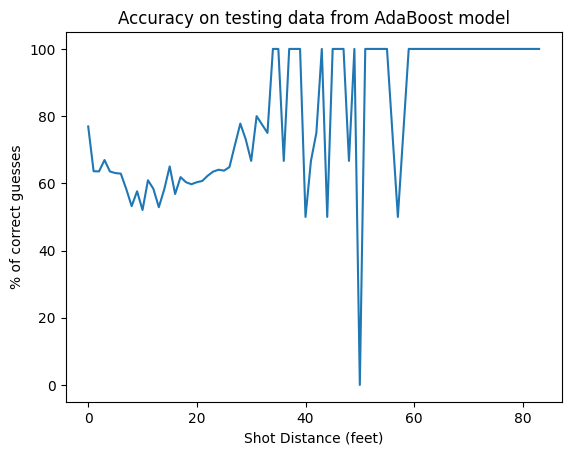

In [36]:
orgByDistance = predicDF.groupby('SHOT_DISTANCE')['correct'].mean()
attemptsByDistance = predicDF.groupby('SHOT_DISTANCE')['SHOT_MADE_FLAG'].count()

xVal = orgByDistance.index
yPer = orgByDistance.values * 100

plt.plot(xVal, yPer)
plt.xlabel('Shot Distance (feet)')
plt.ylabel('% of correct guesses')
plt.title('Accuracy on testing data from AdaBoost model')
plt.show()

In [37]:
predicDFUnder31 = predicDF[predicDF['SHOT_DISTANCE'] < 32]

for x in range(1, 40):
    predicDFUnderX = predicDF[predicDF['SHOT_DISTANCE'] < x]
    print("Under" , x, "feet", sum(predicDFUnderX['correct'])/ len(predicDFUnderX))

# accuracy now
# print(sum(predicDFUnder31['correct'])/ len(predicDFUnder31))
predicDFUnder31

Under 1 feet 0.7693423597678917
Under 2 feet 0.7000697512206464
Under 3 feet 0.6820160750167448
Under 4 feet 0.680607233219229
Under 5 feet 0.6771664374140303
Under 6 feet 0.6739186076273356
Under 7 feet 0.6711063114950804
Under 8 feet 0.6670098375657745
Under 9 feet 0.6612638265250247
Under 10 feet 0.6583791790097334
Under 11 feet 0.6535947712418301
Under 12 feet 0.652242796316467
Under 13 feet 0.65
Under 14 feet 0.6457486136783733
Under 15 feet 0.6436422124921812
Under 16 feet 0.6439108061749571
Under 17 feet 0.6403695225637671
Under 18 feet 0.6392640894271076
Under 19 feet 0.6373456790123457
Under 20 feet 0.6354845490855581
Under 21 feet 0.6344290071162317
Under 22 feet 0.6339208513468574
Under 23 feet 0.6335740072202166
Under 24 feet 0.6336453142093108
Under 25 feet 0.6343829602731559
Under 26 feet 0.6346593734460467
Under 27 feet 0.6350752024681836
Under 28 feet 0.6358210380556749
Under 29 feet 0.6363073994765643
Under 30 feet 0.6364241243286916
Under 31 feet 0.636437054631829
Und

,LOC_X,LOC_Y,SHOT_DISTANCE,SHOT_MADE_PREDICTION,SHOT_MADE_FLAG,correct
17634,88.2755,-8.4625,15,1,0,0
57791,-140.1628,226.9178,3,1,0,0
73687,-138.3065,18.8450,13,1,0,0
29200,-119.5433,219.9283,14,1,0,0
39402,123.2996,84.8203,18,1,1,1
...,...,...,...,...,...,...
1951,-156.7199,-7.9026,18,0,1,0
5740,183.2726,175.2250,25,0,1,0
26876,85.8978,202.0204,25,0,0,1
48856,69.7397,255.4581,27,0,0,1


<h2> Cross validation </h2> 

First divide the data

In [38]:
# divide into equal partitions
def divide_data(df, k):
    splitFrame = np.array_split(df, k)
    return(splitFrame)

Get list of columns

In [39]:
cols = []
for x in important_features_df.columns:
    if x != "SHOT_MADE_FLAG":
        cols.append(x)

Run the experiments

In [40]:
# run k experiments
def run_k_exp(df, k, classifier):
    
    #get split dataframe
    splitDf = divide_data(df, k)
    
    # error counter
    totalError = 0
    
    # iter counter 
    p = 0

    # rotate which one is the testing data
    while p < k:
        test = splitDf[p]
        testDF = pd.DataFrame(test)
        y_test_cv = testDF['SHOT_MADE_FLAG']
        x_test_cv = testDF.drop(columns = ['SHOT_MADE_FLAG'])
        arrWithoutTest = [m for n, m in enumerate(splitDf) if n!=p]
        
        # blank dataframe to append to 
        trainDF = pd.DataFrame(columns = cols)
        
        # make the new training frame
        for x in arrWithoutTest:
            miniDF = pd.DataFrame(x)
            trainDF = trainDF.append(miniDF, ignore_index = True)
        
        # get the x and y for training
        y_train_cv = trainDF['SHOT_MADE_FLAG']
        x_train_cv = trainDF.drop(columns = ['SHOT_MADE_FLAG'])
        
        # do modeling
        model = classifier.fit(x_train_cv, y_train_cv)
        cv_predict = model.predict(x_test_cv)
        
        # check as this takes awhile to run
        print("Predictions for %s folds, iteration %s, is done." % (k, p))
        
        # now get accuracy and error
        corr = 0
        w = 0

        while w < len(cv_predict):
            if cv_predict[w] == y_test_cv.values.ravel()[w]:
                corr += 1
            w += 1

        accCV = corr / len(cv_predict)
        errorCV = 1 - accCV
        totalError += errorCV
        
        print("Done with accuracy")
        
        p+=1
        
    avgErrCV = totalError / k
    print("Average Error for %s folds: %s" % (k, avgErrCV))
    
    return avgErrCV        

Run for a certain number of intervals

In [41]:
# do it for an interval of k
def run_for_k_interval(start_k, end_k, model, df):
    errorForAllK = 0
    
    cvCount = start_k
        
    while cvCount <= end_k:
        kError = run_k_exp(df, cvCount, model)
        errorForAllK += kError

        cvCount +=1
    
    intervalLength = end_k - start_k + 1
    return errorForAllK / (intervalLength)

Put it all together and call cross validation

In [42]:
def run_cv():
    
    error = run_for_k_interval(5, 10, AdaBoostClassifier(n_estimators = 50, random_state=4400), important_features_df)
    print("Total average error:", error)

In [43]:
run_cv()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



AttributeError: 'DataFrame' object has no attribute 'append'